In [1]:
import cv2
import torch
import requests
import numpy as np
import torchvision
from PIL import Image
from torch import no_grad
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
# Function to get predictions with optional filtering by object and threshold
def get_predictions(pred, threshold=0.8, objects=None):
    """
    Assign a string name to predicted classes and filter out predictions below a given threshold.Args:
        pred: List containing tuples with class labels, probabilities, and bounding boxes.
        threshold: Minimum probability required to consider a prediction valid.
        objects: Optional list of object names to filter predictions.
    Returns:
        List of tuples containing class name, probability, and bounding box for each valid prediction.
    """
    predicted_classes = [(COCO_INSTANCE_CATEGORY_NAMES[i], p, [(box[0], box[1]), (box[2], box[3])])
                         for i, p, box in zip(list(pred[0]['labels'].numpy()),
                                              pred[0]['scores'].detach().numpy(),
                                              list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes = [stuff for stuff in predicted_classes if stuff[1] > threshold]
    if objects and predicted_classes:
        predicted_classes = [(name, p, box) for name, p, box in predicted_classes if name in objects]
    return predicted_classes

In [3]:
def draw_box(predicted_classes, image, rect_th=1, text_size=1, text_th=1):
    """
    Draw bounding boxes and labels around detected objects in an image.
    Args:
        predicted_classes: List of tuples containing class name, probability, and bounding box.
        image: Image tensor on which boxes and labels will be drawn.
        rect_th: Thickness of the rectangle.
        text_size: Font size of the label text.
        text_th: Thickness of the label text.
    """
    img = (np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()
    for predicted_class in predicted_classes:
        label, probability, box = predicted_class
        t, l = box[0]
        r, b = box[1]
        t, l, r, b = [round(item) for item in [t, l, r, b]]
        cv2.rectangle(img, (t, l), (r, b), (0, 255, 0), rect_th)  # Draw Rectangle
        cv2.putText(img, f"{label}: {str(round(probability, 2))}", (t, l), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [4]:
# Function to clear GPU memory and delete images to free up RAM
def save_RAM(image_=False):
    """
    Clear GPU memory and delete image variables to free up RAM.
    Args:
        image_: Boolean flag to indicate if the image object should be deleted.
    """
    torch.cuda.empty_cache()
    global image, img, pred
    del img, pred
    if image_:
        image.close()
        del image

In [5]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()  # Set the model to evaluation mode

# Disable gradient computation for all parameters
for name, param in model_.named_parameters():
    param.requires_grad = False
print("Model loaded successfully.")

/home/maanav/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maanav/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully.


In [29]:
# Function to get predictions from the model
def model(x):
    with no_grad():
        yhat = model_(x)
    return yhat

In [30]:
# COCO class names
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

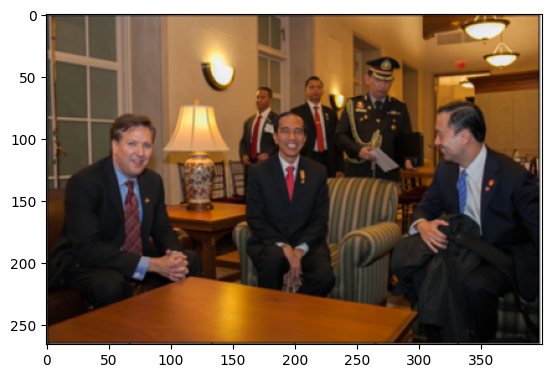

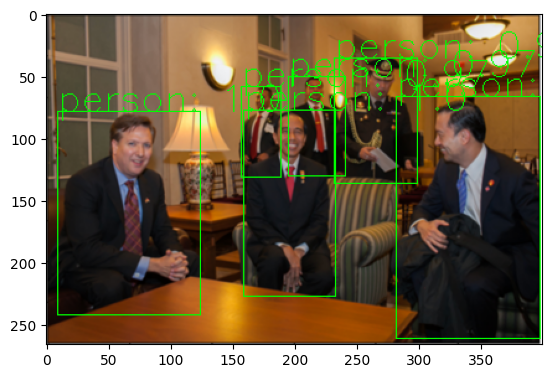

In [32]:
img_path = 'person.png'
image = Image.open(img_path)

# Convert to RGB to ensure it has 3 channels
image = image.convert("RGB")
image = image.resize([int(0.5 * s) for s in image.size])
plt.imshow(image)
plt.show()

transform = transforms.Compose([transforms.ToTensor()])
img = transform(image)  # img should now be of shape [3, H, W]
pred = model([img])  # Pass the tensor to the model
pred_class = get_predictions(pred, objects=["person"])
draw_box(pred_class, img)
save_RAM(image_=True)


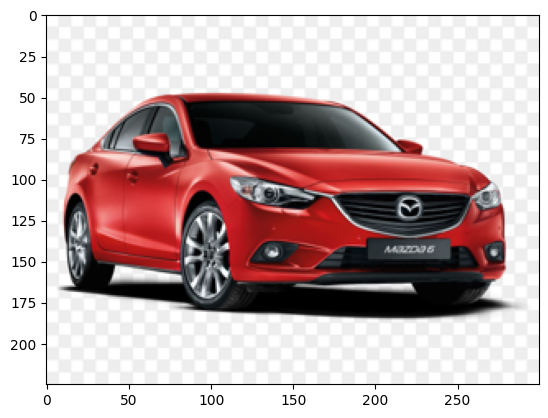

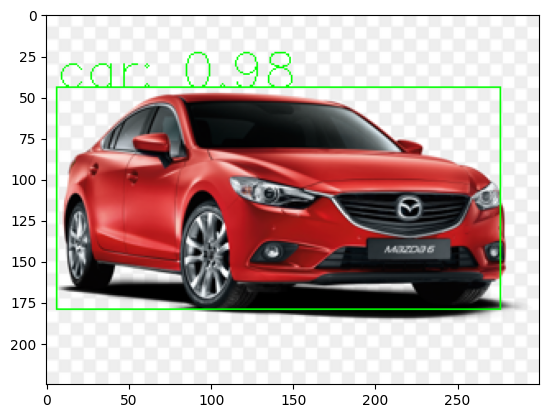

In [35]:
img_path = 'Red-car--PNG.png'

# Open the image
image = Image.open(img_path)

# Convert to RGB to ensure it has 3 channels
image = image.convert("RGB")

# Resize the image to 50% of its original size
image = image.resize([int(0.5 * s) for s in image.size])

# Display the image
plt.imshow(image)
plt.show()

# Transform the image into a tensor
transform = transforms.Compose([transforms.ToTensor()])
img = transform(image)

# Get predictions from the model
pred = model([img])

# Filter predictions based on a threshold
pred_thresh = get_predictions(pred, threshold=0.9)

# Draw bounding boxes around detected objects
draw_box(pred_thresh, img)

# Free up RAM
save_RAM(image_=True)


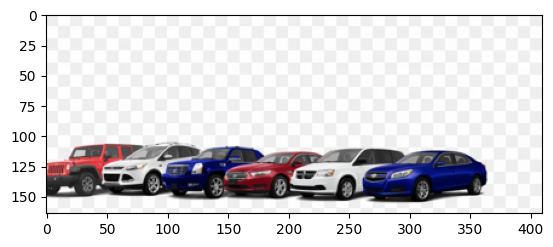

In [ ]:
img_path = 'lot_car.jpg'

# Open the image
image = Image.open(img_path)

# Convert to RGB to ensure it has 3 channels
image = image.convert("RGB")

# Resize the image to 50% of its original size
image = image.resize([int(0.5 * s) for s in image.size])

# Display the image
plt.imshow(image)
plt.show()

# Transform the image into a tensor
transform = transforms.Compose([transforms.ToTensor()])
img = transform(image)

# Get predictions from the model
pred = model([img])

# Filter predictions based on a threshold
pred_thresh = get_predictions(pred, threshold=0.9)

# Draw bounding boxes around detected objects
draw_box(pred_thresh, img)

# Free up RAM
save_RAM(image_=True)
